# **Interpretation of Business Results**

# 0.0. Imports

In [19]:
import pandas                                                           as pd
import numpy                                                            as np
import seaborn                                                          as sns
import matplotlib.pyplot                                                as plt
import pickle
import scikitplot                                                       as skplt
import lightgbm                                                         as lgb

from numerize                       import numerize                     as nm

from IPython.core.display           import HTML
from IPython.display                import Image

import warnings
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [20]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24,12]
    plt.rcParams['font.size'] = 20
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    
    display(HTML ('<style>.container {width: 80% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    palette = ["#856088","#7BA05B", "#7BAFD4", "#FFC40C", "#B53389"]
    colors = sns.color_palette(palette=palette)
    sns.set_palette(colors)
    
jupyter_settings()

In [21]:
def ranking_metrics (data, model, yhat, k=20000):
    # propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clientes by propensity score
    data = data.sort_values('score', ascending=False)

    # reset index - start recall and precision
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    # create precision
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    precision_at_k =  data.loc[k, 'precision_at_k']
    # create recall
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    recall_at_k = data.loc[k, 'recall_at_k']

    return pd.DataFrame ( {'Precision_Top_K': np.round((precision_at_k),4),
                           'Recall_Top_K': np.round((recall_at_k),4),
                           'Model Name': type(model).__name__,
                            }, index = [0] )


def curve(y_val, yhat, axvline=None, axhline=None):
    fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

    # Accumulative Gain
    skplt.metrics.plot_cumulative_gain(y_val, yhat, ax=axs[0])

    if axhline is not None:
        axs[0].axhline(axhline, color='#006D6F', ls='--', lw=2)

    # Lift Curve
    skplt.metrics.plot_lift_curve(y_val, yhat, ax=axs[1])

    if axvline is not None:
        axs[0].axvline(axvline, 0, 1, color='#006D6F', ls='--', lw=2)
        axs[1].axvline(axvline, 0, 1, color='#006D6F', ls='--', lw=2)


## 0.2. Model

In [22]:
lgb_model_tuned = pickle.load(open ('../src/models/lgbm.pkl', 'rb'))
yhat_lgb_tuned = pickle.load(open ('../src/models/yhat_lgbm.pkl', 'rb'))

In [23]:
cols_selected = ['age', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel']

## 0.3. Loading Data

### 0.3.1. Raw

In [24]:
df_raw = pd.read_csv('../data/raw/train.csv')

In [25]:
df_raw.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


In [26]:
df_raw['Response'].value_counts().reset_index()

,index,Response
0,0,334399
1,1,46710


### 0.3.2. Data Description

In [27]:
df_desc = pd.read_csv('../data/interim/df3_data_description_done.csv')

In [28]:
df_desc.head(2)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_associated,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0


### 0.3.3. Enconding

In [29]:
train_encod = pd.read_csv('../data/interim/train_enconding.csv')
val_encod = pd.read_csv('../data/interim/validation_enconding.csv')
test_encod = pd.read_csv('../data/interim/test_enconding.csv')

df_encod = pd.concat ([train_encod, val_encod, test_encod], sort=False)
df_encod = df_encod.sort_values(by='id')

In [30]:
df_encod.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_associated,response
41163,1,0.139414,0.369231,1,0.279330,0,0.041966,1,0.579324,0.211355,0.716263,1
15806,2,0.138012,0.861538,1,0.024185,0,0.525126,0,0.174024,0.208385,0.598616,0
176616,3,0.138012,0.415385,1,0.278743,0,0.042085,1,0.452186,0.208385,0.058824,1
53146,4,0.139414,0.015385,1,0.024943,1,0.431893,0,-0.114982,0.353587,0.667820,0
50910,5,0.105247,0.138462,1,0.047768,1,0.431490,0,-0.173766,0.352733,0.100346,0


In [31]:
df_compared = df_desc.copy()
df_compared['response'] = df_desc['response'].copy()
y = df_desc['response'].copy()

In [32]:
full_en = df_encod[cols_selected].copy()

df_result=  df_raw.copy()

yhat_final = lgb_model_tuned.predict_proba(full_en)
df_result['score'] = yhat_final[:,1].tolist()


df_result = df_result.sort_values('score', ascending=False)
df_result = df_result.reset_index(drop=True)
df_result['ranking'] = df_result.index+1

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.6778865985229834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6778865985229834
[LightGBM] [Warning] bagging_fraction is set=0.8599008768798327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8599008768798327


In [33]:
df_result.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,score,ranking
0,236502,Male,33,1,11.0,0,1-2 Year,Yes,23660.0,163.0,190,0,0.865356,1
1,8726,Male,34,1,11.0,0,1-2 Year,Yes,26195.0,163.0,157,1,0.865356,2
2,175650,Male,36,1,11.0,0,1-2 Year,Yes,26286.0,163.0,292,1,0.864366,3
3,134823,Male,35,1,23.0,0,1-2 Year,Yes,28768.0,163.0,21,0,0.863884,4
4,207740,Male,29,1,11.0,0,1-2 Year,Yes,29492.0,163.0,283,1,0.863723,5


In [35]:
ticket_medio = round(df_desc['annual_premium'].sum() / df_desc.shape[0] , 2)
seguro_auto = round((ticket_medio * 0.40),2)
custo = 1250

# 1.0. Evaluation: Scenarios

In [36]:
print (f"Dos {df_desc.shape[0]} clientes, {round(df_desc.loc[df_desc['response'] == 1].shape[0])} estão interessados no seguro automóvel - {round(df_desc.loc[df_desc['response'] == 1].shape[0] / df_desc.shape[0] *100 ,2) }% do total de clientes")
print (f"O ticket médio para um seguro saúde anual da Insurance All é: ₹{ticket_medio}.")

print (f"\nOs cenários de faturamento serão calculados, levando em conta as premissas abaixo: \n- todos os clientes interessando irão adquirir adquirir o seguro automóvel; \n- o ticket médio do seguro automóvel anual corresponde a 40% do ticket médio do seguro saúde.\n- o custo de ligação por cada cliente é de ₹1250.")

Dos 381109 clientes, 46710 estão interessados no seguro automóvel - 12.26% do total de clientes
O ticket médio para um seguro saúde anual da Insurance All é: ₹30564.39.

Os cenários de faturamento serão calculados, levando em conta as premissas abaixo: 
- todos os clientes interessando irão adquirir adquirir o seguro automóvel; 
- o ticket médio do seguro automóvel anual corresponde a 40% do ticket médio do seguro saúde.
- o custo de ligação por cada cliente é de ₹1250.


### 1.1. **COM 20.000 CHAMADAS TELEFÔNICAS:**  
#### *Com uma equipe de vendas fazendo 20.000 ligações, qual é a porcentagem de clientes interessados em adquirir um seguro automóvel?*


In [37]:
percent20 = 20000 / df_result.shape[0]
ranking_metrics (df_compared, lgb_model_tuned, yhat_final, k=20000)

,Precision_Top_K,Recall_Top_K,Model Name
0,0.4209,0.1802,LGBMClassifier


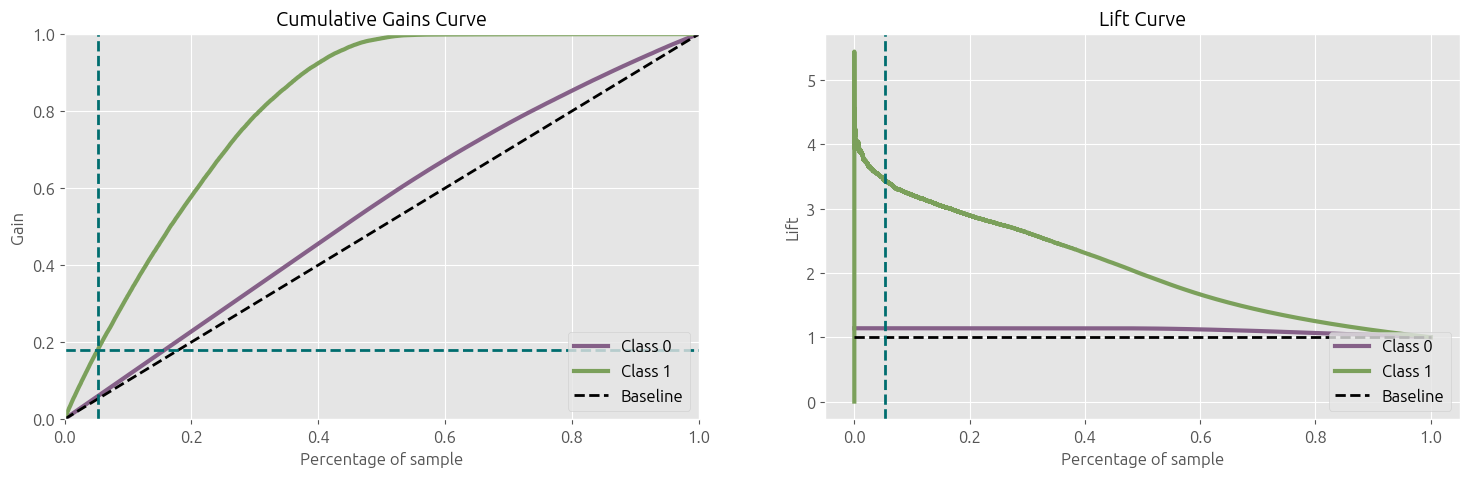

In [38]:
curve(y, yhat_final, axvline=percent20, axhline=0.1802)

#### **Receita**

In [39]:
print(f"Por lista aleatória:")
print (f" - Dos {df_result.shape[0]} clientes da Insurance All, cerca de {round(percent20*100)}% deles estão interessados pelo seguro automóvel. \nLogo pode-se esperar que das 20.000 ligações, haverá {round( (20000 / df_result.shape[0]*100 ) / 100 * (round(df_result.loc[df_result['Response'] == 1].shape[0])) )} contratos, e uma receita estimada de ₹{nm.numerize((2451 * (seguro_auto) - (2451 * (custo))))} por ano.")

print (f"\nPor lista ordenada (modelo):")
print (f" - Dos {df_result.shape[0]} clientes da Insurance All, cerca de {round(0.1802*100)}% deles estão interessados pelo seguro automóvel. \nLogo pode-se esperar que das 20.000 ligações, haverá {round(0.1802 * 100 / 100 * (df_result.loc[df_result['Response' ] == 1].shape[0]) )} novos contratos, e uma receita estimada de ₹{nm.numerize((8417 * (seguro_auto) - (8417 * (custo))))} por ano.")


Por lista aleatória:
 - Dos 381109 clientes da Insurance All, cerca de 5% deles estão interessados pelo seguro automóvel. 
Logo pode-se esperar que das 20.000 ligações, haverá 2451 contratos, e uma receita estimada de ₹26.9M por ano.

Por lista ordenada (modelo):
 - Dos 381109 clientes da Insurance All, cerca de 18% deles estão interessados pelo seguro automóvel. 
Logo pode-se esperar que das 20.000 ligações, haverá 8417 novos contratos, e uma receita estimada de ₹92.38M por ano.


#### **Modelo**

In [40]:
print (f"\nRESULTADO: O uso do modelo produzirá resultados {round((8417 * (seguro_auto)) / (2451 * (seguro_auto)) ,2)} vezes melhores que a lista aleatória e a receita estimada é ₹{nm.numerize((8417 * (seguro_auto) - (8417 * (custo))) - (2451 * (seguro_auto)- (2451 * (custo))))}.")


RESULTADO: O uso do modelo produzirá resultados 3.43 vezes melhores que a lista aleatória e a receita estimada é ₹65.48M.


### 1.2 **COM 40.000 CHAMADAS TELEFÔNICAS** 

#### *E se a capacidade da equipe de vendas aumentar para 40.000 ligações, qual será o percentual de clientes interessados em adquirir um seguro de automóvel?*


In [41]:
percent40 = 40000 / df_result.shape[0]
ranking_metrics (df_compared, lgb_model_tuned, yhat_final, k=40000 )

,Precision_Top_K,Recall_Top_K,Model Name
0,0.3912,0.335,LGBMClassifier


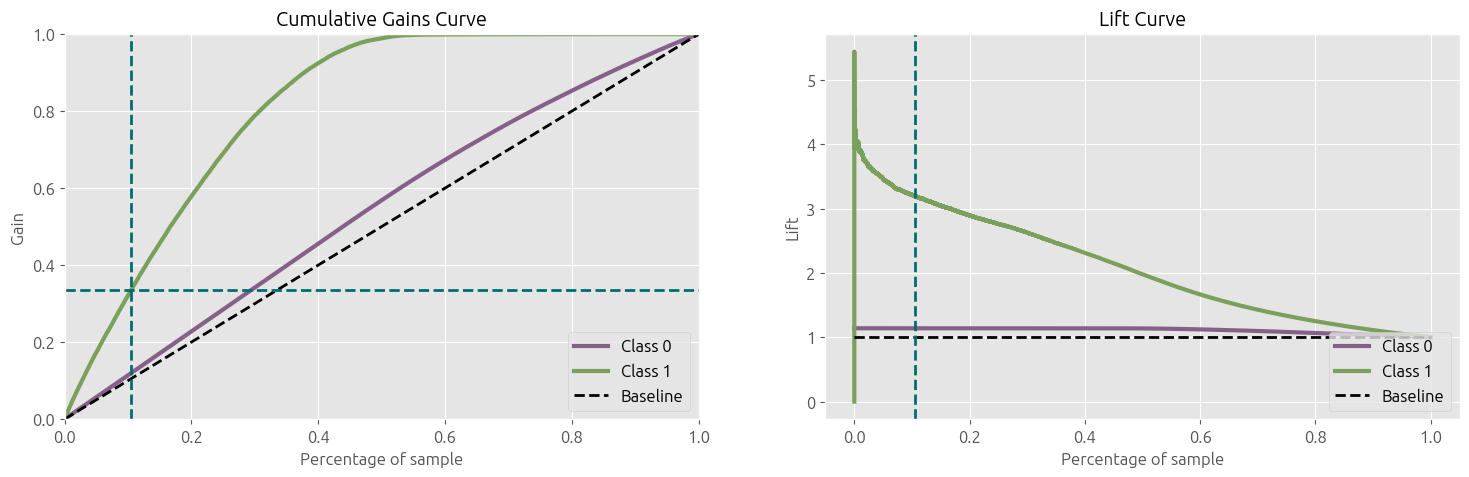

In [42]:
curve(y, yhat_final, axvline=percent40, axhline=0.335)


#### **Receita**

In [43]:
print(f"Por lista aleatória:")
print (f" - Dos {df_result.shape[0]} clientes da Insurance All, cerca de {round(percent40*100)}% deles estão interessados pelo seguro automóvel. \nLogo pode-se esperar que das 40.000 ligações, haverá {round( (40000 / df_result.shape[0]*100 ) / 100 * (round(df_result.loc[df_result['Response'] == 1].shape[0])) )} contratos, e uma receita estimada de ₹{nm.numerize((4903 * (seguro_auto) - (4903 * (custo))))} por ano.")

print (f"\nPor lista ordenada (modelo):")
print (f" - Dos {df_result.shape[0]} clientes da Insurance All, cerca de {round(0.335*100)}% deles estão interessados pelo seguro automóvel. \nLogo pode-se esperar que das 40.000 ligações, haverá {round(0.335*100 / 100 * (df_result.loc[df_result['Response' ] == 1].shape[0]) )} novos contratos, e uma receita estimada de ₹{nm.numerize((15648 * (seguro_auto) - (15648 * (custo))))} por ano.")


Por lista aleatória:
 - Dos 381109 clientes da Insurance All, cerca de 10% deles estão interessados pelo seguro automóvel. 
Logo pode-se esperar que das 40.000 ligações, haverá 4903 contratos, e uma receita estimada de ₹53.81M por ano.

Por lista ordenada (modelo):
 - Dos 381109 clientes da Insurance All, cerca de 34% deles estão interessados pelo seguro automóvel. 
Logo pode-se esperar que das 40.000 ligações, haverá 15648 novos contratos, e uma receita estimada de ₹171.75M por ano.


#### **Modelo**

In [44]:
print (f"\nRESULTADO: O uso do modelo produzirá resultados {round((15648* (seguro_auto)) / (4903 * (seguro_auto)) ,2)} vezes melhores que a lista aleatória e a receita estimada é ₹{nm.numerize((15648 * (seguro_auto) - (15648 * (custo))) - (4903 * (seguro_auto)- (4903 * (custo))))}.")


RESULTADO: O uso do modelo produzirá resultados 3.19 vezes melhores que a lista aleatória e a receita estimada é ₹117.93M.


### 1.3 **COM OS 80% DOS CLIENTES INTERESSADOS:** 

#### *Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?*



In [45]:
percent80 = 117200 / df_result.shape[0]
ranking_metrics (df_compared, lgb_model_tuned, yhat_final, k=117200 )

,Precision_Top_K,Recall_Top_K,Model Name
0,0.319,0.8003,LGBMClassifier


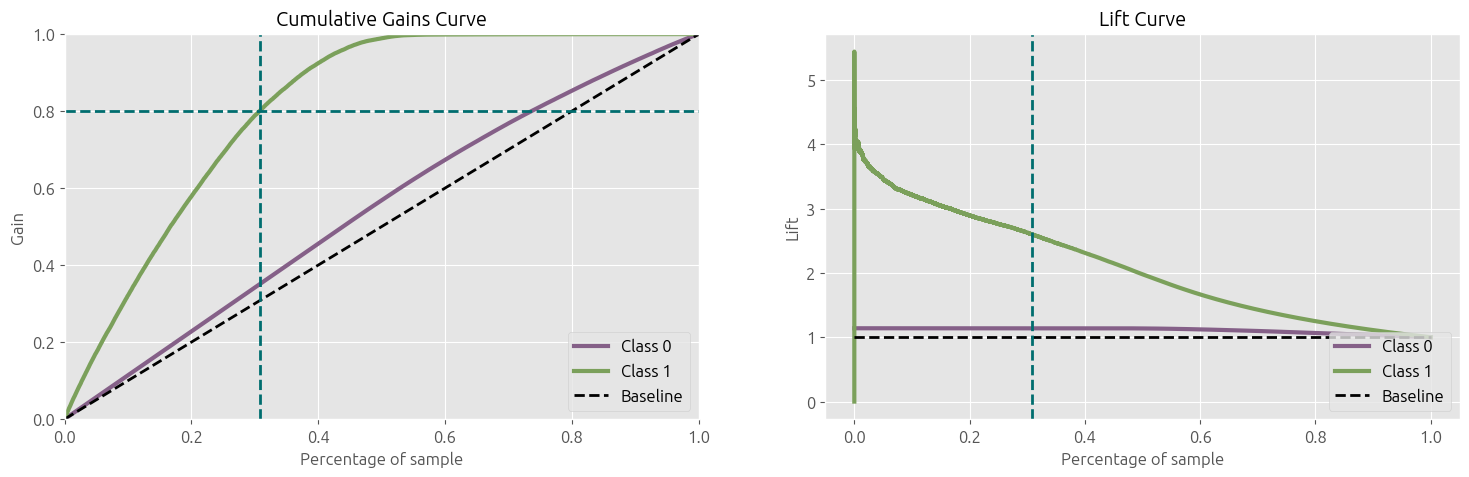

In [46]:
curve(y, yhat_final, axvline=percent80, axhline=0.8003)

#### **Receita**

In [48]:
print(f"Por lista aleatória:")
print (f" - Dos {df_result.shape[0]} clientes da Insurance All, cerca de {round(percent80*100)}% deles estão interessados pelo seguro automóvel. \nLogo pode-se esperar que das 117.200 ligações, haverá {round( (117200 / df_result.shape[0]*100 ) / 100 * (round(df_result.loc[df_result['Response'] == 1].shape[0])) )} contratos, e uma receita estimada de ₹{nm.numerize((14364 * (seguro_auto) - (14364 * (custo))))} por ano.")

print (f"\nPor lista ordenada (modelo):")
print (f" - Dos {df_result.shape[0]} clientes da Insurance All, cerca de {round(0.8003*100)}% deles estão interessados pelo seguro automóvel. \nLogo pode-se esperar que das 117.200 ligações, haverá {round(0.8003*100 / 100 * (df_result.loc[df_result['Response' ] == 1].shape[0]) )} novos contratos, e uma receita estimada de ₹{nm.numerize((37382 * (seguro_auto) - (37382 * (custo))))} por ano.")


Por lista aleatória:
 - Dos 381109 clientes da Insurance All, cerca de 31% deles estão interessados pelo seguro automóvel. 
Logo pode-se esperar que das 117.200 ligações, haverá 14364 contratos, e uma receita estimada de ₹157.66M por ano.

Por lista ordenada (modelo):
 - Dos 381109 clientes da Insurance All, cerca de 80% deles estão interessados pelo seguro automóvel. 
Logo pode-se esperar que das 117.200 ligações, haverá 37382 novos contratos, e uma receita estimada de ₹410.3M por ano.


#### **Modelo**

In [49]:
print (f"\nRESULTADO: O uso do modelo produzirá resultados {round((37382 * (seguro_auto)) / (14364 * (seguro_auto)) ,2)} vezes melhores que a lista aleatória e a receita estimada é ₹{nm.numerize((37382 * (seguro_auto) - (37382 * (custo))) - (14364 * (seguro_auto)- (14364 * (custo))))}.")



RESULTADO: O uso do modelo produzirá resultados 2.6 vezes melhores que a lista aleatória e a receita estimada é ₹252.64M.
